# Racial disparities project extension
## Is there a link between racial bias in the police and the major political orientation of the region?

## 1) Data importation

In [135]:
#LIBRARIES IMPORTATION
#Tools:
import pandas as pd
import numpy as np

#For data loading:
import os
import pickle

#For plotting:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from IPython.display import display_html


#Statistics:
import scipy.stats as stats
import scipy as sp
from statsmodels.stats import diagnostic
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

#Others:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [125]:
#Removing warnings
warnings.filterwarnings('ignore')

In [70]:
#DATASETS IMPORTATION:
df = pd.read_csv('data/opp-stops_state.csv')
counties =  pd.read_csv('2016_US_County_Level_Presidential_Results.csv')

#Dropping Nan values:
df = df.dropna()
counties = counties.dropna()

##Dropping useless data for our analysis
df.drop(columns = ['city', 'geography'], inplace = True)

We now check which states have complete information on hit rate and threshold in order to decide which states we can select for analysis.

In [71]:
#So, we have information on the hit rate and threshold for these states:
print("States with information on hit rate and threshold: ",(df.groupby('state').nunique()).index)

States with information on hit rate and threshold:  Index(['CT', 'IL', 'NC', 'RI', 'SC', 'TX', 'WA', 'WI'], dtype='object', name='state')


We compared with the results of the 2016 US presidential elections on the website https://www.nytimes.com/elections/2016/results/president and selected from these states the ones that were categorically blue (Democrat) or red (Republican).

- Our selected red states are: South Carolina and Texas (SC, TX)
- Our selected blue states are: Illinois, Connecticut, Rhode Island, Washington (IL, CT, RI, WA)

The others do not have a sufficiently marked percentage far away from the 50% (NC), or are swing states that tend to switch parties during elections (WI). 

## 2) Quick data verification:
We now verify that the number of arrests was large enough to have significant results in both groups of states (blue and red). 
We perform the same test on the number of searches, as we compare the hit rates during police stops which involved search specifically.

This is done after first sorting states and counties into the blue and red ones.

In [72]:
#To sort the states between red and blue:
##Definition of array with the names of red and blue states

red_states = ['SC', 'TX']
blue_states  = ['IL', 'CT', 'RI', 'WA']

##Function that returns a string containing the color of the state, according to its name and thanks to the arrays defined above
def what_color (name, blue_, red_):
    """input: name of the state (string) and the arrays with the red and blue states
    output: the color of the state (string)"""
    if any(s == name for s in blue_):
        return 'blue'
    elif any(s == name for s in red_):
        return 'red'
    else:
        return 'none'

##Loop function on all the state of the givcen dataframe to find the color of each one of them
def sort_array_of_state(dataframe, blue_, red_):
    """input: the dataframe to sort, the arrays with the list of the blue and red states
    output: an array with the list of the colors of the states in the same order"""
    colors = []
    for state in dataframe['state']:
        colors.append(what_color(state, blue_, red_))
    return colors
    
##Application of the function on our dataframe of interest
df['party'] = sort_array_of_state(df, blue_states, red_states)

Now that we specified the color of the state, we can proceed with the data verification.

In [73]:
#Data verification:
##Definition of the number of search per year in a county, defined by the number of stops per year multiplied by the search rate.
df['nb_search'] = df['search_rate']*df['stops_per_year']

##To compare them, creation of blue and red dataframe:
blue = df[df['party'].str.contains('blue')]
red = df[df['party'].str.contains('red')]

##Verification
nb_search_red = red['nb_search'].sum()
nb_stops_red = red['stops_per_year'].sum()
nb_search_blue = blue['nb_search'].sum()
nb_stops_blue = blue['stops_per_year'].sum()

print("For red states : number of stops per year: ", nb_stops_red, " and number of searches per year : ", nb_search_red)
print("")
print("For blue states : number of stops per year: ", nb_stops_blue, " and number of searches per year : ", nb_search_blue)

For red states : number of stops per year:  2104964.397693118  and number of searches per year :  47958.64340845877

For blue states : number of stops per year:  1071249.6266666665  and number of searches per year :  29642.008985507244


We can see that the numbers of searches and stops are very large, so we consider our sample to be sufficiently large to continue our research process.

In [74]:
#Reorganisation of dataframe for more meaningful visualization of our dataset
full = pd.concat([blue,red]).reset_index(drop = True)
full_pivot = full.pivot(index = ['party', 'state', 'subgeography'] , columns = 'subject_race')
full_pivot.head()

search_rate                     stop_rate  \
subject_race                        black  hispanic     white     black   
party state subgeography                                                  
blue  CT    Fairfield County     0.029384  0.020520  0.013487  0.073116   
            Hartford County      0.036567  0.036986  0.012005  0.073116   
            Litchfield County    0.034749  0.038982  0.016265  0.073116   
            New Haven County     0.028742  0.030105  0.011492  0.073116   
            New London County    0.031647  0.029246  0.014475  0.073116   

                                                   hit_rate            \
subject_race                   hispanic     white     black  hispanic   
party state subgeography                                                
blue  CT    Fairfield County   0.039236  0.065458  0.315113  0.257426   
            Hartford County    0.039236  0.065458  0.303398  0.294776   
            Litchfield County  0.039236  0.065458  0.301587  0.438776   
            New Haven County   0.039236  0.065458  0.247191  0.302548   
            New London County  0.039236  0.065458  0.331683  0.325926   

                                        inferred_threshold  ...            \
subject_race                      white              black  ...     white   
party state subgeography                                    ...             
blue  CT    Fairfield County   0.356108           0.171864  ...  0.223550   
            Hartford County    0.319820           0.155822  ...  0.238114   
            Litchfield County  0.413978           0.184323  ...  0.262494   
            New Haven County   0.357401           0.166497  ...  0.233488   
            New London County  0.335580           0.172387  ...  0.225318   

                              stops_per_year                    stop_rate_n  \
subject_race                           black hispanic     white       black   
party state subgeography                                                      
blue  CT    Fairfield County         5080.32  4725.12  17189.76    25650.72   
            Hartford County          5408.16  3623.00  17752.80    25650.72   
            Litchfield County         906.50  1257.00  16466.88    25650.72   
            New Haven County         5945.28  5006.40  23139.36    25650.72   
            New London County        3063.84  2215.68  24605.76    25650.72   

                                                   nb_search                   
subject_race                   hispanic      white     black hispanic   white  
party state subgeography                                                       
blue  CT    Fairfield County   21654.72  160113.12    149.28    96.96  231.84  
            Hartford County    21654.72  160113.12    197.76   134.00  213.12  
            Litchfield County  21654.72  160113.12     31.50    49.00  267.84  
            New Haven County   21654.72  160113.12    170.88   150.72  265.92  
            New London County  21654.72  160113.12     96.96    64.80  356.16  

[5 rows x 21 columns]

We will be examining hit rates and threshold, they are computed individually for each subject race and each county. As stated in the paper, the hit rate .....
### EXPLIQUER C'EST QUOI LA HIT RATE C QUOI LE TRESHOLD

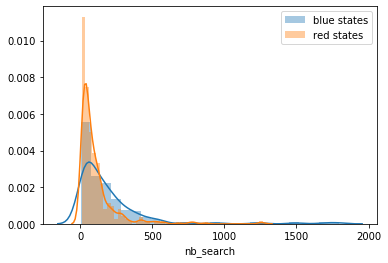

In [75]:
g = sns.distplot(blue.nb_search, label = 'blue states')
sns.distplot(red.nb_search, label = 'red states', ax = g)
plt.legend()

As we can see the number of searches per county and per subject race follows a power law distribution. This is indeed due to the fact that, like city sizes, county sizes follow a power law distribution since there is a majority of small, low population counties with a heavy tail of large counties with high population.

In [76]:
sns.displot(data=full, x="hit_rate", hue="subject_race", col="party", kde = True)
sns.displot(data=full, x="inferred_threshold", hue="subject_race", col="party", kde=True)

blue.hit_rate.mean(), red.hit_rate.mean()

AttributeError: module 'seaborn' has no attribute 'displot'

These distributions hint that there may be an underlying subdistribution in the red states. This is probably due to only having two red states which may have rather different policing trends. We can also note that the values are quite far from being normally distributed.

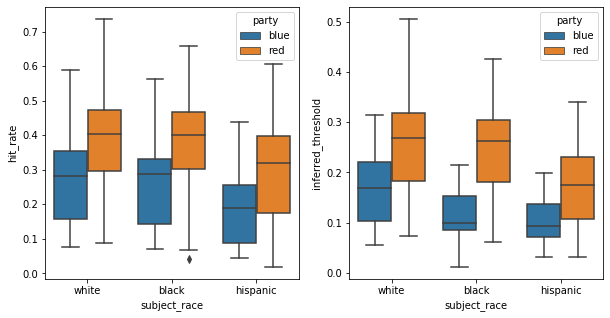

In [77]:
# Boxplots also give a good representation of distribution:
fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.boxplot(data=full, y="hit_rate", x="subject_race", hue = 'party', ax = ax[0])
sns.boxplot(data=full, y="inferred_threshold", x="subject_race", hue = 'party', ax = ax[1])

We describe here our two variables of interest over our whole working dataset (blue and red states).
Values between races look overall pretty close, with decreasing values (for all parameters) when one goes from white to black to hispanic drivers. Note also that values are lower in blue states than in red states, for all parameters and race. Of course this does not mean anything on the disparities _between_ races.

Now its time to test our data to compare their means and see if there is significant difference between subdatasets. 
To do that we first need to distribution the data follows, to be able to apply adapted statistical tests.

#### Data distribution
So, we want to know if the county specific, race specific hit rates and thresholds have normal distribution: we perform the Kolmogorov-Smirnov statistical test, which will test the null hypothesis according to which the distribution if normal (in our case). If the pvalue is too low, we will reject this null hypothesis.

To be more precise, we performed this test over the blue and red dataframes separately.
Here are the results of the statistical test for blue and red states respectively:

In [78]:
print(diagnostic.kstest_normal(blue.hit_rate, dist = 'norm'))
print(diagnostic.kstest_normal(blue.inferred_threshold, dist = 'norm'))

print(diagnostic.kstest_normal(red.hit_rate, dist = 'norm'))
print(diagnostic.kstest_normal(red.inferred_threshold, dist = 'norm'))

(0.09609983831289304, 0.0017443959573869524)
(0.12182864323923764, 1.1071663662289254e-05)
(0.06421953443341571, 0.00015549236465630696)
(0.05568339671858269, 0.0021810060008734204)


We can already see how some distribution are not normal (null hypothesis rejected for example for hit rates in blue states). For the other, we can't conclude anything about their distribution. Therefore, we will proceed as if none on them were normally distributed.

#### Data intercorrelation 
We would like to spot any correlation between the parameters we study. The Spearman test measures the dependency between two variables. It is recommended when the variables do not follow a normal law. We perform this test between inferred threshold, hit rates and number of searches per county. 

In [53]:
print(stats.spearmanr(full['inferred_threshold'],full['hit_rate']))
print(stats.spearmanr(full['nb_search'],full['hit_rate']))
print(stats.spearmanr(full['nb_search'],full['inferred_threshold']))

SpearmanrResult(correlation=0.8849066121281508, pvalue=1.3341319855978963e-198)
SpearmanrResult(correlation=-0.1407706070012973, pvalue=0.0005800000393526619)
SpearmanrResult(correlation=-0.22249093550713708, pvalue=4.253593680944105e-08)


We can see that, of course, hit rate and inferred threshold are correlated. It is logical as they reflect linked informations. No correlation is found with the number of searches (correlation close to zero).

## 3) Visualizing hit rates and thresholds

In [80]:
#Useful dataframes to do that:
##red statess
black_red = red[red['subject_race'].str.contains('black')]
white_red = red[red['subject_race'].str.contains('white')]
hisp_red  = red[red['subject_race'].str.contains('hispanic')]

hit_black_red = black_red[['subgeography', 'hit_rate', 'nb_search']]
white_red = white_red.set_index(hit_black_red.index)
hit_black_red['hit_white'] = white_red['hit_rate']

thres_black_red = black_red[['subgeography', 'inferred_threshold', 'nb_search']]
thres_black_red['thres_white'] = white_red['inferred_threshold']

hit_hisp_red = hisp_red[['subgeography', 'hit_rate', 'nb_search']]
white_red = white_red.set_index(hit_hisp_red.index)
hit_hisp_red['hit_white'] = white_red['hit_rate']

thres_hisp_red = hisp_red[['subgeography', 'inferred_threshold', 'nb_search']]
thres_hisp_red['thres_white'] = white_red['inferred_threshold']

##blue states
black_blue = blue[blue['subject_race'].str.contains('black')]
white_blue = blue[blue['subject_race'].str.contains('white')]
hisp_blue  = blue[blue['subject_race'].str.contains('hispanic')]

hit_black_blue = black_blue[['subgeography', 'hit_rate', 'nb_search']]
white_blue = white_blue.set_index(hit_black_blue.index)
hit_black_blue['hit_white'] = white_blue['hit_rate']

thres_black_blue = black_blue[['subgeography', 'inferred_threshold', 'nb_search']]
thres_black_blue['thres_white'] = white_blue['inferred_threshold']

hit_hisp_blue = hisp_blue[['subgeography', 'hit_rate', 'nb_search']]
white_blue = white_blue.set_index(hit_hisp_blue.index)
hit_hisp_blue['hit_white'] = white_blue['hit_rate']

thres_hisp_blue = hisp_blue[['subgeography', 'inferred_threshold', 'nb_search']]
thres_hisp_blue['thres_white'] = white_blue['inferred_threshold']

In [81]:
#This function plots the hit rate or threshold rate of white people vs black or hispanic people. It takes as input
#the axis for the figure, the color of the state, which rate is being represented, the title of the graphe, and the
#specific dataframes necessary for the graph.
def plot_rates(ax,color,rate,title,df_white,df_black,df_hisp,lim):
    if color == 'blue':
        eg1 = '#7C6FFB'
        eg2 = '#6FCBFB'
        
    else:
        eg1 = '#FF315F'
        eg2 = '#FF6331'
  
    s1 = df_black['nb_search'].values
    s2 = df_hisp['nb_search'].values
    ax.scatter(df_white[rate]*100, df_black[rate]*100,  s = s1, facecolors='none', edgecolors=eg1, label = 'Black')
    ax.scatter(df_white[rate]*100, df_hisp[rate]*100,  s = s2, facecolors='none', edgecolors=eg2, label = 'Hispanic')
    
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    
    ax.plot([0,1],[0,1], linestyle = '--', linewidth = 1, color='black',transform=ax.transAxes)
    
    lgnd = ax.legend()
    
    div = make_axes_locatable(ax)
    ax = div.append_axes("top", size="10%", pad=0)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_facecolor('gainsboro')
    at = AnchoredText(title, loc=10, prop=dict(backgroundcolor='gainsboro', size=13, color='black'))
    ax.add_artist(at) 
    
    lgnd.legendHandles[0].set_sizes([65])
    lgnd.legendHandles[1].set_sizes([65])

Text(0.08, 0.5, 'Minority threshold (%)')

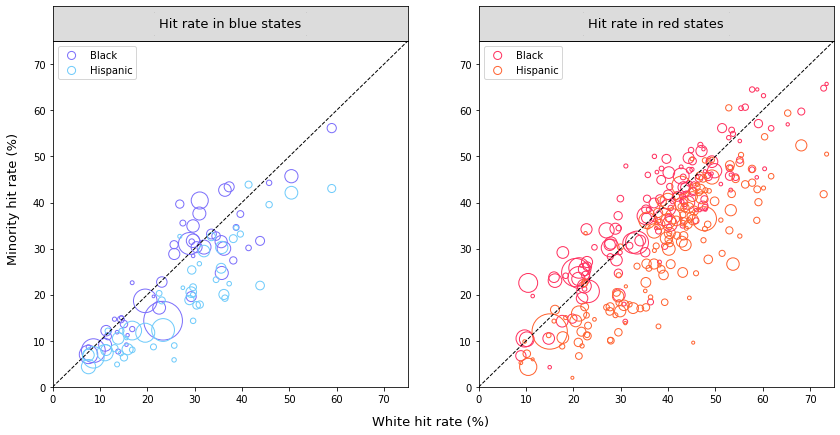

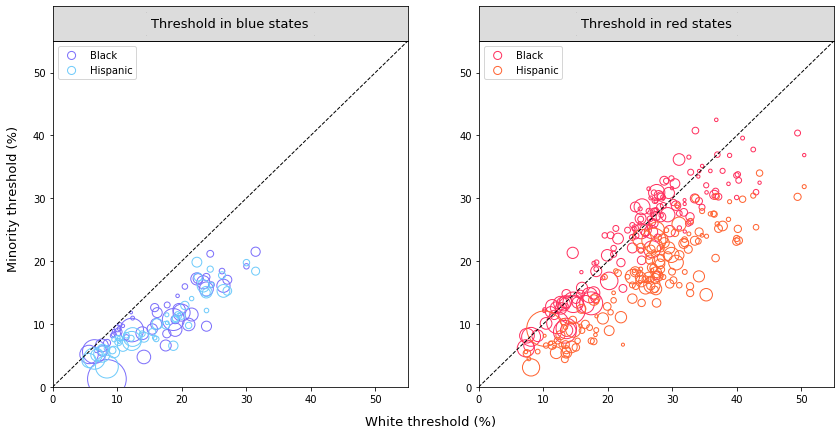

In [82]:
#We now use the function above to plot the data
fig, ax = plt.subplots(1,2,figsize=(14,7))
plot_rates(ax[0],'blue','hit_rate',"Hit rate in blue states",white_blue,black_blue,hisp_blue,[0,75])
plot_rates(ax[1],'red','hit_rate',"Hit rate in red states",white_red,black_red,hisp_red,[0,75])
fig.text(0.5, 0.05, 'White hit rate (%)', ha='center', fontsize = 13)
fig.text(0.08, 0.5, 'Minority hit rate (%)', va='center', rotation='vertical', fontsize = 13)

fig, ax = plt.subplots(1,2,figsize=(14,7))
plot_rates(ax[0],'blue','inferred_threshold',"Threshold in blue states",white_blue,black_blue,hisp_blue,[0,55])
plot_rates(ax[1],'red','inferred_threshold',"Threshold in red states",white_red,black_red,hisp_red,[0,55])
fig.text(0.5, 0.05, 'White threshold (%)', ha='center', fontsize = 13)
fig.text(0.08, 0.5, 'Minority threshold (%)', va='center', rotation='vertical', fontsize = 13)

#### Data observation
Visually, one can see that the hit rates and thresholds for non-Caucasian minorities are generally lower than their equivalent for white drivers: a large part of the points are below the diagonal, with a particulary clear distance from the diagonal in the thershold plot for blue states. 

Visually, we tend to say that:
- there is more points below the diagonal than on and above it
- for the hit rates: in both state groups, points for hispanic drivers are further below the diagonal than for black drivers. Searches on hispanic drivers have lower relative hit rates than the ones on black drivers.
- for the threshold: in red states, we observe the same pattern, with lower threshold for hispanic drivers than for black drivers. In blue states however, we observe the same disparity for both race.
- there are a large amount of points in red states and far less in blue states, which can trouble and bias visualization.

Note: the size of the points correspond to the number of police search per year for this race in the county considered

## 4) Quantified alternative for comparison and example
In order to quantify this information and compare it with more reliable statistical tools than a simple visual comparison, we have computed a new value: the minority/white ratio. This makes it possible to compare these values across the counties and for the different minorities studied. For example, for the threshold for Hispanic drivers in the red states, the value will be the threshold for Hispanic drivers divided by the threshold for white drivers.

We will calculate a weighted average within the red and blue states respectively. 
This is done by giving each county a race specific weight (such that the sum of weights is one) and then calculating the weighted sum of hit rate or threshold. 
Each row will hence get a weight: 
w(i) = nb_search(i)/sum(nb_search of corresponding race in dataframe)

This will be done for blue and red dataframe so as to give higher weight to counties with a lot of searches and less to counties with few. It is important to do it separately for the blue and red dataframes since we will calculate averages over these dataframes.

In [84]:
# get weight is a function to apply to columns of race specific number of searches for the blue and red dataframes separately
def get_weight(nb_search):
    return nb_search/nb_search.sum()
# get normalize is a function to apply to each row of rate dataframes containing a column for each race
def get_normalize(values):
    return values/values.white

In [85]:
import warnings
warnings.filterwarnings('ignore')

weights = full_pivot.loc['blue'].nb_search.apply(get_weight, axis = 0).stack('subject_race').reset_index().rename(columns = {0:'weight'})
blue = blue.merge(weights, on = ['subgeography','state', 'subject_race'])

weights = full_pivot.loc['red'].nb_search.apply(get_weight, axis = 0).stack('subject_race').reset_index().rename(columns = {0:'weight'})
red = red.merge(weights, on = ['subgeography','state', 'subject_race'])

#create dataframes with normalized values, using the pivoted dataframe so we can apply get normalize to each row containing race specific rates
hit_rate_normalized = full_pivot.hit_rate.apply(get_normalize, axis = 1).stack('subject_race').reset_index().rename(columns = {0:'hit_rate_normalized'})
threshold_normalized = full_pivot.inferred_threshold.apply(get_normalize, axis = 1).stack('subject_race').reset_index().rename(columns = {0:'threshold_normalized'})

blue = blue.merge(hit_rate_normalized.merge(threshold_normalized), on = ['subgeography','state', 'subject_race','party'])
red = red.merge(hit_rate_normalized.merge(threshold_normalized), on = ['subgeography','state', 'subject_race','party'])

blue['hit_rate_weighted'] = blue.hit_rate*blue.weight
blue['threshold_weighted'] = blue.inferred_threshold*blue.weight
red['hit_rate_weighted'] = red.hit_rate*red.weight
red['threshold_weighted'] = red.inferred_threshold*red.weight
blue['hit_rate_weighted_normalized'] = blue.hit_rate_normalized*blue.weight
blue['threshold_weighted_normalized'] = blue.threshold_normalized*blue.weight
red['hit_rate_weighted_normalized'] = red.hit_rate_normalized*red.weight
red['threshold_weighted_normalized'] = red.threshold_normalized*red.weight

In [103]:
#Creation of a useful dataframe with both red and blue stated informations.
df_model = pd.concat([red, blue])
df_model.head()

,state,subgeography,subject_race,search_rate,stop_rate,hit_rate,inferred_threshold,stops_per_year,stop_rate_n,party,nb_search,weight,hit_rate_normalized,threshold_normalized,hit_rate_weighted,threshold_weighted,hit_rate_weighted_normalized,threshold_weighted_normalized
0,SC,Aiken County,white,0.046344,0.152224,0.326098,0.135749,14778.447761,474888.537313,red,684.895522,0.030084,1.000000,1.000000,0.009810,0.004084,0.030084,0.030084
1,SC,Aiken County,black,0.047768,0.198882,0.311993,0.093137,8785.074627,262767.044776,red,419.641791,0.031066,0.956746,0.686097,0.009692,0.002893,0.029722,0.021314
2,SC,Aiken County,hispanic,0.097844,0.113592,0.171032,0.054565,1188.000000,30374.149254,red,116.238806,0.009948,0.524481,0.401955,0.001701,0.000543,0.005218,0.003999
3,SC,Anderson County,white,0.025694,0.152224,0.277738,0.165177,29465.373134,474888.537313,red,757.074627,0.033255,1.000000,1.000000,0.009236,0.005493,0.033255,0.033255
4,SC,Anderson County,black,0.036149,0.198882,0.301578,0.131444,8789.552239,262767.044776,red,317.731343,0.023522,1.085836,0.795777,0.007094,0.003092,0.025541,0.018718


In [92]:
# function to plot the bar plots nicely
def plot_bar(method, data, params, ylab):
    ylim, ax = params
    sns.barplot(x = "state", y = method, hue = data.index, hue_order = ['hispanic','black'], data = data, ax = ax)
    ax.set_ylim(ylim)
    ax.set_xlim([-0.5,5.5])
    ax.set_xlabel('State', fontsize = 13)
    ax.set_ylabel(ylab, fontsize = 13)
    ax.axhline(y=1, ls = (1, (10,5)), color = 'black', lw = 0.7)
    x = np.arange(-0.5, 3.5, 0.01)
    ax.fill_between(x, ylim[0],ylim[1], color = "#5DADE2", alpha =0.5)    
    x = np.arange(3.5, 6, 0.01)
    ax.fill_between(x, ylim[0],ylim[1], color = "#E74C3C", alpha =0.5)

ValueError: cannot reindex from a duplicate axis

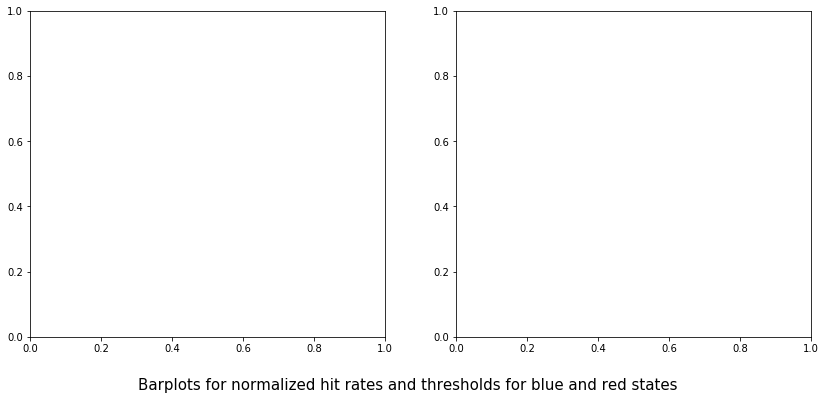

In [93]:
# prepare data
data = pd.concat([blue.set_index(['subject_race']).loc[['black','hispanic']],red.set_index(['subject_race']).loc[['black','hispanic']]])

# prepare arguments to plotting function
methods = ["hit_rate_normalized", "threshold_normalized"]
ylim = [[0,1.25], [0,1.05]]
ylab = ["Hit rate, normalized", "Threshold, normalized"]

fig, axs = plt.subplots(1,2,figsize=(14,6))
plt.suptitle("Barplots for normalized hit rates and thresholds for blue and red states", size=15, y=0.03)
for method in range(2):
    params = [ylim[method],axs[method]]
    plot_bar(methods[method],data, params, ylab[method])

##   

#### Calculation of means and statistical testing for racial bias in blue vs red states

Our objective is to compare our independent variables (hit rate and inferred threshold) between blue and red states. Nevertheless, the visualizations are not enough to see a difference. Therefore, we will carry out tests on these variables to determine if significant differences exist between blue and red states. 

First we will calculate the mean race specific hit rates and thresholds for blue states and red states. This can be done by giving each county an equal weight (unweighted mean) or giving each county a weight proportional to the race specific number of searches (weighted mean).
Then we choose a statistical test and carry it out to compare race specific, party specific mean hit rates and thresholds.

In [94]:
results_blue = pd.concat([blue.groupby('subject_race').mean().loc[:,['hit_rate','inferred_threshold','hit_rate_normalized','threshold_normalized']],
          blue.groupby('subject_race').sum().loc[:,'hit_rate_weighted':]],
          axis =1).T
results_red = pd.concat([red.groupby('subject_race').mean().loc[:,['hit_rate','inferred_threshold','hit_rate_normalized','threshold_normalized']],
          red.groupby('subject_race').sum().loc[:,'hit_rate_weighted':]],
          axis =1).T

In [95]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
display_side_by_side(results_blue,results_red)

subject_race,black,hispanic,white
hit_rate,0.255677,0.190342,0.266144
inferred_threshold,0.112942,0.103911,0.166598
hit_rate_normalized,0.960909,0.698504,1.000000
threshold_normalized,0.704567,0.631549,1.000000
hit_rate_weighted,0.233233,0.160692,0.211490
threshold_weighted,0.085460,0.085563,0.134161
hit_rate_weighted_normalized,0.908968,0.689212,1.000000
threshold_weighted_normalized,0.571677,0.618790,1.000000
subject_race,black,hispanic,white
hit_rate,0.384179,0.294927,0.389270


Here we have two tables (blue on the left red, on the right), they contain party average race specific hit rates and inferred thresholds given no change, normalization with respect to white values, weighted average calculation and weighted average of normalized data.

Comparing red results vs blue results shows that normalized means are lower in blue states than in red states. Also, while weighted means tend to be lower than their unweighted equivalent in blue states, the opposite trend is seen in red states. This causes the differences between normalized means to be even bigger between red and blue states for the weighted case.

Regardless, statistical tests are necessary in order to quantify the significance of difference in means between red and blue states. 

We use the Mann-Whitneyu test to compare the means since we assume the that the distributions are not normal. The null hypothesis states that means from blue and red states are the same. The null hypothesis is rejected in the case that the p value is less than 0.05. Rejection of the null hypothesis supports the claim that the means are significantly different. 

In [97]:
# compare normalized hit rate and threshold between red and blue
# We use mannwhitney test because we ar comparing two samples but our values distribution are not normal
print(stats.mannwhitneyu(full_pivot.loc['blue'].hit_rate.hispanic, full_pivot.loc['red'].hit_rate.hispanic, alternative='two-sided'))
print(stats.mannwhitneyu(blue[blue.subject_race == 'hispanic'].hit_rate_normalized, 
                         red[red.subject_race == 'hispanic'].hit_rate_normalized, alternative='two-sided'))


MannwhitneyuResult(statistic=2042.0, pvalue=2.228258922536633e-06)
MannwhitneyuResult(statistic=3195.0, pvalue=0.14982340226194957)


We can see that normalizing is important as it does not give the same results at all. Without normalization the means are clearly not the same. The non-normalized hit rates test supports the claim that the means are significantly different . Meanwhile, the test for normalized hit rates does not enable us to reject the hypothesis that the means are different. Therefore it is imperative to only compare normalized values (as will be done from now on).

Lets check out some more tests: 

In [98]:
print("mean black threshold pvalue:", stats.mannwhitneyu(blue[blue.subject_race == 'black'].threshold_normalized, 
                         red[red.subject_race == 'black'].threshold_normalized, alternative='two-sided')[1])
print("mean hispanic threshold pvalue:", stats.mannwhitneyu(blue[blue.subject_race == 'hispanic'].threshold_normalized, 
                         red[red.subject_race == 'hispanic'].threshold_normalized, alternative='two-sided')[1])

print("mean black hit rate pvalue:", stats.mannwhitneyu(blue[blue.subject_race == 'black'].hit_rate_normalized, 
                         red[red.subject_race == 'black'].hit_rate_normalized, alternative='two-sided')[1])
print("mean hispanic hit rate pvalue:",stats.mannwhitneyu(blue[blue.subject_race == 'hispanic'].hit_rate_normalized, 
                         red[red.subject_race == 'hispanic'].hit_rate_normalized, alternative='two-sided')[1])

mean black threshold pvalue: 3.514390445469963e-16
mean hispanic threshold pvalue: 0.08968318516587746
mean black hit rate pvalue: 0.19645575200757714
mean hispanic hit rate pvalue: 0.14982340226194957


Given these p values we can only reject the null hypothesis for mean black thresholds, suggesting bias in black thresholds for blue states. The rest of p values are small but not low enough to reject the null hypothesese. 


In [99]:
print("p values for weighted tests:")
print("black hit rate:",stats.mannwhitneyu(np.repeat(blue[blue.subject_race == 'black'].hit_rate_normalized, blue[blue.subject_race == 'black'].nb_search), 
                         np.repeat(red[red.subject_race == 'black'].hit_rate_normalized, red[red.subject_race == 'black'].nb_search),
                         alternative='two-sided')[1])
print("hispanic hit rate:", stats.mannwhitneyu(np.repeat(blue[blue.subject_race == 'hispanic'].hit_rate_normalized, blue[blue.subject_race == 'hispanic'].nb_search), 
                         np.repeat(red[red.subject_race == 'hispanic'].hit_rate_normalized, red[red.subject_race == 'hispanic'].nb_search),
                         alternative='two-sided')[1])
print("black threshold:", stats.mannwhitneyu(np.repeat(blue[blue.subject_race == 'black'].threshold_normalized, blue[blue.subject_race == 'black'].nb_search), 
                         np.repeat(red[red.subject_race == 'black'].threshold_normalized, red[red.subject_race == 'black'].nb_search),
                         alternative='two-sided')[1])
print("hispanic threshold:", stats.mannwhitneyu(np.repeat(blue[blue.subject_race == 'hispanic'].threshold_normalized, blue[blue.subject_race == 'hispanic'].nb_search), 
                         np.repeat(red[red.subject_race == 'hispanic'].threshold_normalized, red[red.subject_race == 'hispanic'].nb_search),
                         alternative='two-sided')[1])

p values for weighted tests:
black hit rate: 0.0
hispanic hit rate: 3.313033909600949e-235
black threshold: 0.0
hispanic threshold: 1.0150732922276061e-206


#### Prediction model
To investigate further, we will try to estimate the weighted ratio mentioned above from the other parameters of the dataframe. In this way, we will be able to observe whether the trained model gives importance to political preference in the county in question. For this, we have added to our data the percentage obtained by the majority party. We created an index (called purcent in the dataframe) which is the difference between the party score and the majority (50%), which we multiplied by -1 if the chosen party is the republican party. This gives for example for Texas where the republican party won at 52.2% an index of -2.2. Similarly, the state of Illinois where the Democrats won at 55.2% will have an index of 5.2.It is important that, for the moment, we evaluate political trends at the state level: state colour and state percentage.

In [113]:
# Adding the scores for each state:
illinois = 5.2
ct = 4.6
ri = 4.4
sc = -4.9
texas = -2.2
results = [illinois, ct, ri, sc, texas]

def what_percent (name, results):
    [illinois, ct, ri, sc, texas] =  results
    if (name == 'IL'):
        return illinois
    if (name == 'CT'):
        return ct
    if (name == 'RI'):
        return ri
    if (name == 'SC'):
        return sc
    if (name == 'TX'):
        return texas
    else:
        return 0.0


def find_state_percent(df, results):
    purcentage = []
    for state in df['state']:
        purcentage.append(what_percent(state, results))
    return purcentage

df_model['state_percent'] = find_state_percent(df_model, results)
df_model.head(1)

,state,subgeography,subject_race,search_rate,stop_rate,hit_rate,inferred_threshold,stops_per_year,stop_rate_n,party,nb_search,weight,hit_rate_normalized,threshold_normalized,hit_rate_weighted,threshold_weighted,hit_rate_weighted_normalized,threshold_weighted_normalized,state_percent
0,SC,Aiken County,white,0.046344,0.152224,0.326098,0.135749,14778.447761,474888.537313,red,684.895522,0.030084,1.0,1.0,0.00981,0.004084,0.030084,0.030084,-4.9


In [114]:
df_model.dropna()
mod_state = smf.logit(formula='hit_rate_weighted_normalized ~ party + subject_race +  state_percent', data=df_model)
res_state = mod_state.fit(method='ncg')
print(res_state.summary())

Optimization terminated successfully.
         Current function value: 0.010320
         Iterations: 9
         Function evaluations: 9
         Gradient evaluations: 9
         Hessian evaluations: 9
                                Logit Regression Results                                
Dep. Variable:     hit_rate_weighted_normalized   No. Observations:                  594
Model:                                    Logit   Df Residuals:                      589
Method:                                     MLE   Df Model:                            4
Date:                          Fri, 18 Dec 2020   Pseudo R-squ.:                     inf
Time:                                  19:45:32   Log-Likelihood:                -6.1301
converged:                                 True   LL-Null:                        0.0000
Covariance Type:                      nonrobust   LLR p-value:                     1.000
                               coef    std err          z      P>|z|      [0.025      0

Now for the thresholds:


In [115]:
mod_state1 = smf.logit(formula='threshold_weighted_normalized ~ party + subject_race +  state_percent', data=df_model)
res_state1 = mod_state1.fit(method='ncg')
print(res_state1.summary())

Optimization terminated successfully.
         Current function value: 0.009029
         Iterations: 9
         Function evaluations: 9
         Gradient evaluations: 9
         Hessian evaluations: 9
                                 Logit Regression Results                                
Dep. Variable:     threshold_weighted_normalized   No. Observations:                  594
Model:                                     Logit   Df Residuals:                      589
Method:                                      MLE   Df Model:                            4
Date:                           Fri, 18 Dec 2020   Pseudo R-squ.:                     inf
Time:                                   19:46:18   Log-Likelihood:                -5.3635
converged:                                  True   LL-Null:                        0.0000
Covariance Type:                       nonrobust   LLR p-value:                     1.000
                               coef    std err          z      P>|z|      [0.02

We can see that no coefficients estimated by this model prediction is significant to predict the normalized, weighted hit rate or threshold. 

# How to be even more accurate and precise: visualization, comparison and prediction at the county-level
As mentioned earlier, we have only looked at state-level political trends. If political trends and police bias are indeed linked, we need clear political outcomes, for example at the county level which would be more precise and give more accurate results. This is important because within the same state with a score that is not obvious (e.g. 52.2% red for Texas) there are counties with scores as high as 94.6% for Republicans in Roberts County or completely opposite, e.g. 65.8% for Democrats in Travis County.
We have therefore looked for data on the results at the county level and will use it to refine our study.
First, let's look at the hit rates and thersholds for white and Hispanic drivers in different counties in the state of Texas.

## 5) County data visualization

In [116]:
tx = df.loc[df["state"] == "TX"]
counties['party'] = np.where(counties["per_dem"] > counties["per_gop"], "blue", "red")
counties = counties.loc[counties["state_abbr"] == "TX"]
tx = tx.drop(['state','party'],axis=1)
tx = pd.merge(left=tx, right=counties, left_on='subgeography', right_on='county_name')
tx = tx.drop(['votes_dem','votes_gop','state_abbr','county_name','combined_fips','Unnamed: 0'],axis=1)

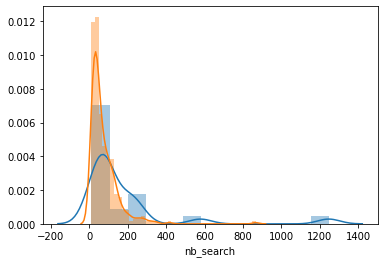

In [117]:
g = sns.distplot(tx[tx.party == 'blue'].nb_search, label = 'blue states')
sns.distplot(tx[tx.party == 'red'].nb_search, label = 'red states', ax = g)


We can see that there are more blue counties with high number of searches and that again most red counties have small number of searches.

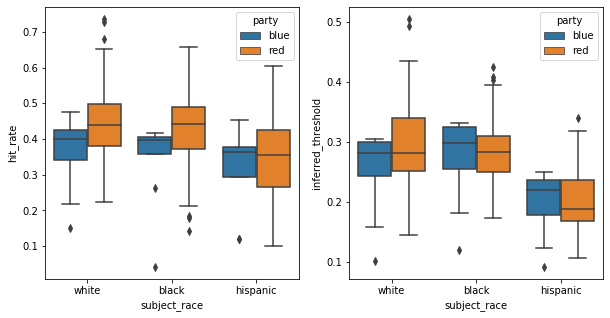

In [118]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.boxplot(data=tx, y="hit_rate", x="subject_race", hue = 'party', hue_order = ['blue', 'red'], ax = ax[0])
sns.boxplot(data=tx, y="inferred_threshold", x="subject_race", hue = 'party', hue_order = ['blue', 'red'], ax = ax[1])

This box plot shows the values for hit rates and thresholds are quite spread out, especially for red counties. Again, blue hit rates are lower than red hit rates.

In [119]:
sns.displot(data=tx, x="hit_rate", hue="subject_race", col="party", kde = True)
sns.displot(data=tx, x="inferred_threshold", hue="subject_race", col="party", kde=True)

AttributeError: module 'seaborn' has no attribute 'displot'

Visualizing the distribution is complementary to the box plot. It allows to make links with spread of quartiles while also showing crucial difference in counts. Notably the difference in counts between subject races and between parties. This difference is normal as most counties in texas are red. Nevertheless, the blue counties each have a high number of searches.  

In [120]:
tx.groupby('party').sum().nb_search

party
blue     4153.925524
red     23681.255198
Name: nb_search, dtype: float64

There are a lot less total searches for blue counties than for red counties but both numbers are high enough to justify analysis.

In [121]:
print("p values for testing normality of value distributions")
print(diagnostic.kstest_normal(tx.hit_rate, dist = 'norm')[1])
print(diagnostic.kstest_normal(tx.inferred_threshold, dist = 'norm')[1])
print(diagnostic.kstest_normal(full_pivot.loc['blue'].hit_rate.white, dist = 'norm')[1])
print(diagnostic.kstest_normal(full_pivot.loc['blue'].inferred_threshold.hispanic, dist = 'norm')[1])
print(diagnostic.kstest_normal(full_pivot.loc['red'].hit_rate.white, dist = 'norm')[1])
print(diagnostic.kstest_normal(full_pivot.loc['red'].inferred_threshold.hispanic, dist = 'norm')[1])

p values for testing normality of value distributions
0.0016159384242767961
0.2
0.09447775923365336
0.008741859308381885
0.2
0.025689232069145678


We see that some distributions reject the null hypothesis and some do not. For simplicity we will assume the variables are not normally distributed.
Now, test of the correlation between parameters: 
We only test the correlation between hit rate and number of searches, and between threshold and number of searches. (Because the correlation between hit rates and thesholds have already been found at the state level and will not be checked again as it is quite obvious).

In [124]:
print(stats.spearmanr(tx[tx.subject_race == 'hispanic']['nb_search'],tx[tx.subject_race == 'hispanic']['hit_rate']))
print(stats.spearmanr(tx[tx.subject_race == 'hispanic']['nb_search'],tx[tx.subject_race == 'hispanic']['inferred_threshold']))
print(stats.spearmanr(tx[tx.subject_race == 'white']['nb_search'],tx[tx.subject_race == 'white']['hit_rate']))
print(stats.spearmanr(tx[tx.subject_race == 'white']['nb_search'],tx[tx.subject_race == 'white']['inferred_threshold']))
print(stats.spearmanr(tx[tx.subject_race == 'black']['nb_search'],tx[tx.subject_race == 'black']['hit_rate']))
print(stats.spearmanr(tx[tx.subject_race == 'black']['nb_search'],tx[tx.subject_race == 'black']['inferred_threshold']))

SpearmanrResult(correlation=0.045208524370740265, pvalue=0.634449800186034)
SpearmanrResult(correlation=-0.18638132942976915, pvalue=0.04808827366712917)
SpearmanrResult(correlation=-0.07690964136003728, pvalue=0.4181294387137159)
SpearmanrResult(correlation=-0.20668374476013046, pvalue=0.028061653207698344)
SpearmanrResult(correlation=-0.07280938687176161, pvalue=0.44344618296034977)
SpearmanrResult(correlation=-0.25533135937188106, pvalue=0.0063444404542834)


Once again, either no correlation (correlation close to zero) or non significant pvalues. We conclude that there's no correlation between the number of searches and other parameters.

## 6) Visualization of hit rates and thresholds racial bias for blue and red counties

In [127]:
tx_white = tx.loc[tx["subject_race"]== 'white']
tx_white_b = tx_white.loc[tx_white['party'] == 'blue']
tx_white_r = tx_white.loc[tx_white['party'] == 'red']
tx_black = tx.loc[tx["subject_race"]== 'black']
tx_black_b = tx_black.loc[tx_black['party'] == 'blue']
tx_black_r = tx_black.loc[tx_black['party'] == 'red']
tx_hisp = tx.loc[tx["subject_race"]== 'hispanic']
tx_hisp_b = tx_hisp.loc[tx_hisp['party'] == 'blue']
tx_hisp_r = tx_hisp.loc[tx_hisp['party'] == 'red']

Text(0.08, 0.5, 'Minority threshold, Texas (%)')

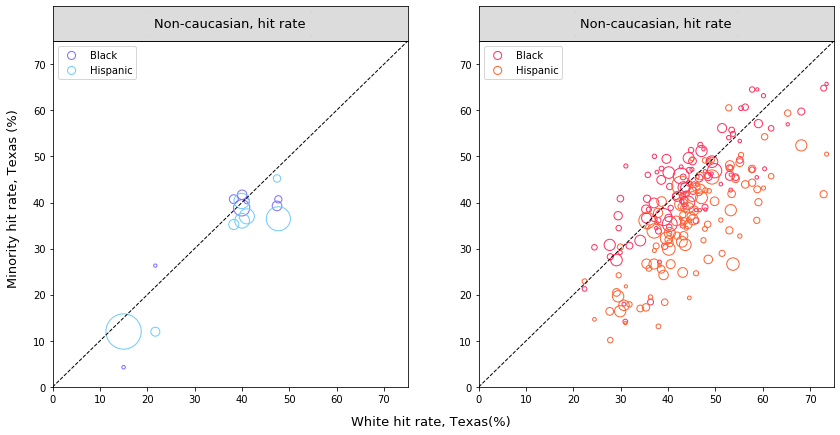

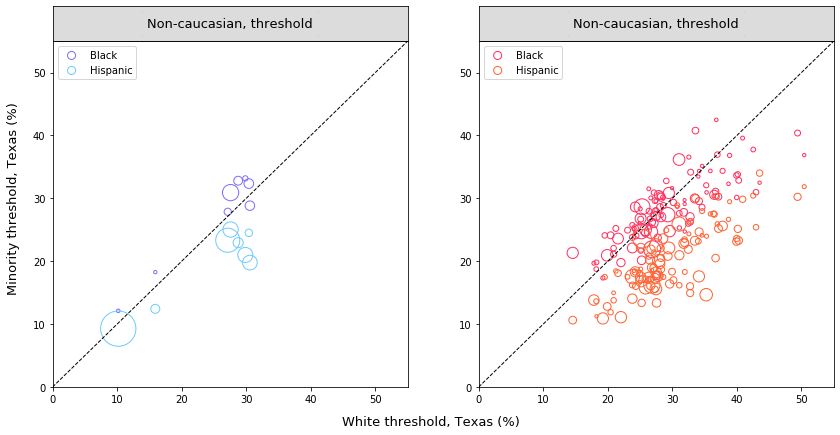

In [128]:
fig, ax = plt.subplots(1,2,figsize=(14,7))
plot_rates(ax[0],'blue','hit_rate',"Non-caucasian, hit rate",tx_white_b,tx_black_b,tx_hisp_b,[0,75])
plot_rates(ax[1],'red','hit_rate',"Non-caucasian, hit rate",tx_white_r,tx_black_r,tx_hisp_r,[0,75])
fig.text(0.5, 0.05, 'White hit rate, Texas(%)', ha='center', fontsize = 13)
fig.text(0.08, 0.5, 'Minority hit rate, Texas (%)', va='center', rotation='vertical', fontsize = 13)

fig, ax = plt.subplots(1,2,figsize=(14,7))
plot_rates(ax[0],'blue','inferred_threshold',"Non-caucasian, threshold",tx_white_b,tx_black_b,tx_hisp_b,[0,55])
plot_rates(ax[1],'red','inferred_threshold',"Non-caucasian, threshold",tx_white_r,tx_black_r,tx_hisp_r,[0,55])
fig.text(0.5, 0.05, 'White threshold, Texas (%)', ha='center', fontsize = 13)
fig.text(0.08, 0.5, 'Minority threshold, Texas (%)', va='center', rotation='vertical', fontsize = 13)

### Data observation
We have clearly too few points in blue states to allow a clear and obvious conclusion. However we can observe that:
- red counties tend to have very spread points that can go quite far below the diagonal
- blue counties points are not numerous but some represent a very large number of police searches. Their repartition is globally close to the diagonal
- a disparity remains between black and hispanic drivers, with hispanic hit rates and thresholds further from the diagonal than black ones
- many relative hit rates and threshold for black drivers are even above the diagonal


## 7) Comparison of means for counties
### Creation of useful dataframes

In [136]:
pivot_tx = tx.pivot(index = ['party', 'subgeography'] , columns = 'subject_race')

In [137]:
weights = pivot_tx.loc['blue'].nb_search.apply(get_weight, axis = 0).stack('subject_race').reset_index().rename(columns = {0:'weight'})
tx_blue = tx[tx.party == 'blue'].merge(weights, on = ['subgeography','subject_race'])

weights = pivot_tx.loc['red'].nb_search.apply(get_weight, axis = 0).stack('subject_race').reset_index().rename(columns = {0:'weight'})
tx_red = tx[tx.party == 'red'].merge(weights, on = ['subgeography','subject_race'])

#create dataframes with normalized values, using the pivoted dataframe so we can apply get normalize to each row containing race specific
hit_rate_normalized = pivot_tx.hit_rate.apply(get_normalize, axis = 1).stack('subject_race').reset_index().rename(columns = {0:'hit_rate_normalized'})
threshold_normalized = pivot_tx.inferred_threshold.apply(get_normalize, axis = 1).stack('subject_race').reset_index().rename(columns = {0:'threshold_normalized'})
hit_rate_normalized
threshold_normalized
tx_blue = tx_blue.merge(hit_rate_normalized.merge(threshold_normalized), on = ['subgeography', 'subject_race','party'])
tx_red = tx_red.merge(hit_rate_normalized.merge(threshold_normalized), on = ['subgeography', 'subject_race','party'])

tx_blue['hit_rate_weighted'] = tx_blue.hit_rate*tx_blue.weight
tx_blue['threshold_weighted'] = tx_blue.inferred_threshold*tx_blue.weight
tx_red['hit_rate_weighted'] = tx_red.hit_rate*tx_red.weight
tx_red['threshold_weighted'] = tx_red.inferred_threshold*tx_red.weight
tx_blue['hit_rate_weighted_normalized'] = tx_blue.hit_rate_normalized*tx_blue.weight
tx_blue['threshold_weighted_normalized'] = tx_blue.threshold_normalized*tx_blue.weight
tx_red['hit_rate_weighted_normalized'] = tx_red.hit_rate_normalized*tx_red.weight
tx_red['threshold_weighted_normalized'] = tx_red.threshold_normalized*tx_red.weight

In [138]:
results_blue = pd.concat([tx_blue.groupby('subject_race').mean().loc[:,['hit_rate','inferred_threshold','hit_rate_normalized','threshold_normalized']],
          tx_blue.groupby('subject_race').sum().loc[:,'hit_rate_weighted':]],
          axis =1).T
results_red = pd.concat([tx_red.groupby('subject_race').mean().loc[:,['hit_rate','inferred_threshold','hit_rate_normalized','threshold_normalized']],
          tx_red.groupby('subject_race').sum().loc[:,'hit_rate_weighted':]],
          axis =1).T

In [150]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
display_side_by_side(results_blue,results_red)

subject_race,black,hispanic,white
hit_rate,0.340110,0.317911,0.363883
inferred_threshold,0.270343,0.197877,0.250464
hit_rate_normalized,0.904808,0.850641,1.000000
threshold_normalized,1.092983,0.801940,1.000000
hit_rate_weighted,0.388619,0.251140,0.395255
threshold_weighted,0.303134,0.163061,0.273854
hit_rate_weighted_normalized,0.953272,0.828129,1.000000
threshold_weighted_normalized,1.082935,0.852314,1.000000
subject_race,black,hispanic,white
hit_rate,0.434453,0.345940,0.445877


Once again, performing the Mann-Whitney test to test the null hypotesis stating that both means are close.
pvalue obtained for thresholds for black drivers in red and blue counties (very low, null hypothesis rejected, mean are not close) :

In [151]:
print("Black threshold pvalue:", stats.mannwhitneyu(tx_blue[tx_blue.subject_race == 'black'].threshold_normalized, 
                         tx_red[tx_red.subject_race == 'black'].threshold_normalized, alternative='two-sided')[1])

Black threshold pvalue: 0.0073392688282188515


Pvalue obtained for thresholds for hispanic drivers in red and blue counties (very low, null hypothesis rejected, mean are not close) :

In [152]:
print("Hispanic threshold pvalue:", stats.mannwhitneyu(tx_blue[tx_blue.subject_race == 'hispanic'].threshold_normalized, 
                         tx_red[tx_red.subject_race == 'hispanic'].threshold_normalized, alternative='two-sided')[1])

Hispanic threshold pvalue: 0.006414154504411466


Pvalue obtained for hit rates for black drivers in red and blue counties (very low, null hypothesis rejected, mean are not close) :

In [153]:
print("Black hit rate pvalue:", stats.mannwhitneyu(tx_blue[tx_blue.subject_race == 'black'].hit_rate_normalized, 
                         tx_red[tx_red.subject_race == 'black'].hit_rate_normalized, alternative='two-sided')[1])

Black hit rate pvalue: 0.6422428759499583


Pvalue obtained for hit rates for hispanic drivers in red and blue counties (very low, null hypothesis rejected, mean are not close) :

In [154]:
print("Hispanic hit rate pvalue:",stats.mannwhitneyu(tx_blue[tx_blue.subject_race == 'hispanic'].hit_rate_normalized, 
                         tx_red[tx_red.subject_race == 'hispanic'].hit_rate_normalized, alternative='two-sided')[1])

Hispanic hit rate pvalue: 0.14100577845491272


ValueError: cannot reindex from a duplicate axis

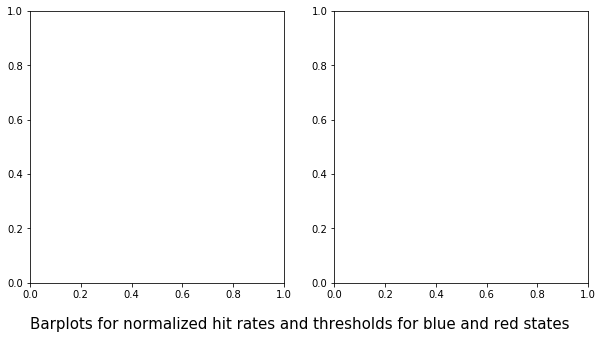

In [155]:
# Process data
data = pd.concat([tx_blue.set_index(['subject_race']).loc[['black','hispanic']],tx_red.set_index(['subject_race']).loc[['black','hispanic']]])

# Prepare arguments to plotting function
methods = ["hit_rate_normalized", "threshold_normalized"]
ylim = [[0,1.25], [0,1.05]]
ylab = ["Hit rate, normalized", "Threshold, normalized"]

fig, axs = plt.subplots(1,2,figsize=(10,5))
plt.suptitle("Barplots for normalized hit rates and thresholds for blue and red states", size=15, y=0.03)
for i in range(2):
    sns.barplot(x = "party", y = methods[i], hue = data.index, hue_order = ['hispanic','black'], data = data, ax = axs[i])
    axs[i].set_xlabel('Party', fontsize = 13)
    axs[i].set_ylabel(ylab[i], fontsize = 13)
    axs[i].axhline(y=1, ls = (1, (10,5)), color = 'black', lw = 0.7)


## 8) Model prediction for the red and blue counties

In [156]:
tx_model_df = pd.concat([tx_red, tx_blue], ignore_index=True)

def process_point_diff(liste):
    new = []
    for s in liste:
        if (type(s) == str):
            s = s[:-1]
        new.append(s)
    return new
tx_model_df['per_point_diff'] = process_point_diff(tx_model_df['per_point_diff'])
tx_model_df['per_point_diff'] = tx_model_df['per_point_diff'].astype(float)

tx_model_df.dropna()
mod = smf.logit(formula='hit_rate_weighted_normalized ~ party + subject_race + per_point_diff +  state_percent', data=tx_model_df)
res = mod.fit(method='ncg')
print(res.summary())

PatsyError: Error evaluating factor: NameError: name 'state_percent' is not defined
    hit_rate_weighted_normalized ~ party + subject_race + per_point_diff +  state_percent
                                                                            ^^^^^^^^^^^^^

In [157]:
mod1 = smf.logit(formula='threshold_weighted_normalized ~ party + subject_race + per_point_diff +  state_percent', data=tx_model_df)
res1 = mod1.fit(method='ncg')
print(res1.summary())

PatsyError: Error evaluating factor: NameError: name 'state_percent' is not defined
    threshold_weighted_normalized ~ party + subject_race + per_point_diff +  state_percent
                                                                             ^^^^^^^^^^^^^